In [43]:
import evds as ev
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, month_plot
from arch.unitroot import ADF, KPSS
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("api_key.txt") as f:
    api_key = f.read()

In [3]:
evds = ev.evdsAPI(api_key)

In [4]:
dollar = evds.get_data(["TP.DK.USD.S.YTL"], startdate="01-01-2010", enddate="01-11-2023", frequency=5)

dollar.head()

,Tarih,TP_DK_USD_S_YTL
0,2010-1,1.473400
1,2010-2,1.512830
2,2010-3,1.535678
3,2010-4,1.495048
4,2010-5,1.542210


In [5]:
index = evds.get_data(["TP.MK.F.BILESIK"], startdate="01-01-2010", enddate="01-11-2023", frequency=5)

index.head()

,Tarih,TP_MK_F_BILESIK
0,2010-1,540.28
1,2010-2,493.84
2,2010-3,569.89
3,2010-4,587.63
4,2010-5,540.34


In [6]:
cpi = evds.get_data(["TP.FG.J0"], startdate="01-01-2010", enddate="01-11-2023", frequency=5)

cpi.head()

,Tarih,TP_FG_J0
0,2010-1,174.07
1,2010-2,176.59
2,2010-3,177.62
3,2010-4,178.68
4,2010-5,178.04


In [7]:
dollar.rename(columns={dollar.columns[1]: "Dollar/Lira"}, inplace=True)
index.rename(columns={index.columns[1]: "Bist100"}, inplace=True)
cpi.rename(columns={cpi.columns[1]: "CPI"}, inplace=True)

In [8]:
dollar.columns

Index(['Tarih', 'Dollar/Lira'], dtype='object')

In [9]:
data = pd.DataFrame()
data["Dollar/Lira"] = dollar["Dollar/Lira"]
data["Bist100"] = index["Bist100"]
data["CPI"] = cpi["CPI"]

data.head()

,Dollar/Lira,Bist100,CPI
0,1.473400,540.28,174.07
1,1.512830,493.84,176.59
2,1.535678,569.89,177.62
3,1.495048,587.63,178.68
4,1.542210,540.34,178.04


In [10]:
data["Date"] = pd.date_range(start="01.01.2010", periods=len(data), freq="M")
data.set_index("Date", inplace=True)

data.head()

,Dollar/Lira,Bist100,CPI
Date,,,
2010-01-31,1.473400,540.28,174.07
2010-02-28,1.512830,493.84,176.59
2010-03-31,1.535678,569.89,177.62
2010-04-30,1.495048,587.63,178.68
2010-05-31,1.542210,540.34,178.04


In [11]:
data.isnull().sum()

Dollar/Lira    0
Bist100        0
CPI            0
dtype: int64

In [12]:
data.corr()

,Dollar/Lira,Bist100,CPI
Dollar/Lira,1.000000,0.942621,0.994686
Bist100,0.942621,1.000000,0.960598
CPI,0.994686,0.960598,1.000000


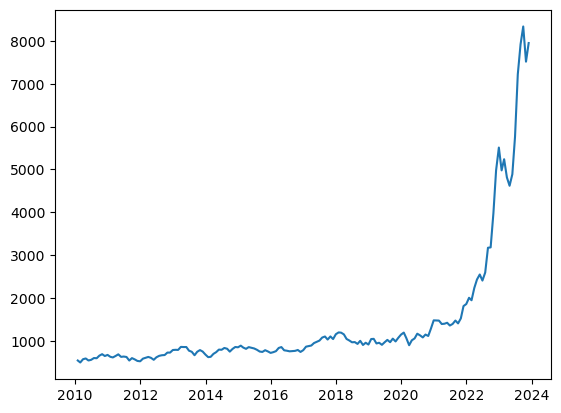

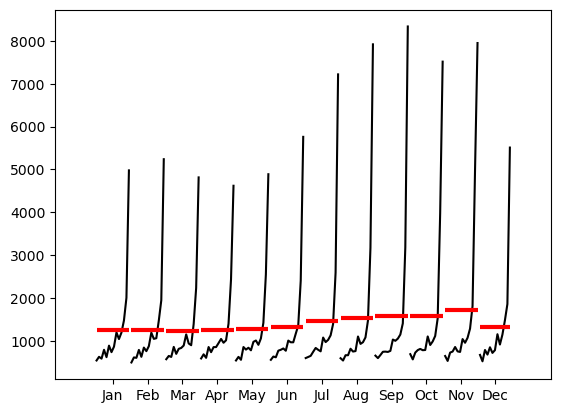

In [13]:
plt.plot(data["Bist100"])
month_plot(data["Bist100"])
plt.show()

In [14]:
# Birim Kök testleri

In [15]:
ADF(data["Bist100"])

Test Statistic,2.902
P-value,1.000
Lags,14


In [16]:
diff = data["Bist100"].diff().dropna().diff().dropna()

In [17]:
ADF(diff)

Test Statistic,-4.451
P-value,0.000
Lags,13


In [18]:
cv = TimeSeriesSplit(n_splits=5)

mae = []

for train_index, test_index in cv.split(data["Bist100"]):
    train, test = data["Bist100"].iloc[train_index], data["Bist100"].iloc[test_index]
    model = Holt(train).fit(optimized=True, use_brute=True)
    predict = model.forecast(len(test))
    mae.append(mean_absolute_error(test, predict))
    
print("Holt Model MAE: ", np.mean(mae))

Holt Model MAE:  669.7242336998072


In [19]:
mae = []

for train_index, test_index in cv.split(data["Bist100"]):
    train, test = data["Bist100"].iloc[train_index], data["Bist100"].iloc[test_index]
    model = ExponentialSmoothing(train, trend="add", seasonal="add", 
                                seasonal_periods=12).fit(optimized=True, use_brute=True)
    predict = model.forecast(len(test))
    mae.append(mean_absolute_error(test, predict))
    
print("Holt Winters Model MAE: ", np.mean(mae))

Holt Winters Model MAE:  639.4179294709577


In [20]:
mae = []

for train_index, test_index in cv.split(data["Bist100"]):
    train, test = data["Bist100"].iloc[train_index], data["Bist100"].iloc[test_index]
    model = auto_arima(train, trace=False, seasonal=False)
    predict = model.predict(len(test))
    mae.append(mean_absolute_error(test, predict))
    
print("ARIMA Model MAE: ", np.mean(mae))

ARIMA Model MAE:  671.0263545121777


In [21]:
mae = []

for train_index, test_index in cv.split(data["Bist100"]):
    train, test = data["Bist100"].iloc[train_index], data["Bist100"].iloc[test_index]
    model = auto_arima(train, trace=False, seasonal=True, m=12)
    predict = model.predict(len(test))
    mae.append(mean_absolute_error(test, predict))
    
print("SARIMA Model MAE: ", np.mean(mae))

SARIMA Model MAE:  649.897681520352


In [22]:
mae = []

for train_index, test_index in cv.split(data["Bist100"]):
    train, test = data["Bist100"].iloc[train_index], data["Bist100"].iloc[test_index]
    train_exog, test_exog = data["Dollar/Lira"].iloc[train_index], data["Dollar/Lira"].iloc[test_index]
    train_exog = np.array(train_exog).reshape(-1,1)
    test_exog = np.array(test_exog).reshape(-1,1)
    model = auto_arima(train, trace=False, seasonal=False, X=train_exog)
    predict = model.predict(len(test), X=test_exog)
    mae.append(mean_absolute_error(test, predict))
    
print("ARIMAX_1 Model MAE: ", np.mean(mae))

ARIMAX_1 Model MAE:  849.1531680654168


In [23]:
mae = []

for train_index, test_index in cv.split(data["Bist100"]):
    train, test = data["Bist100"].iloc[train_index], data["Bist100"].iloc[test_index]
    train_exog, test_exog = data["CPI"].iloc[train_index], data["CPI"].iloc[test_index]
    train_exog = np.array(train_exog).reshape(-1,1)
    test_exog = np.array(test_exog).reshape(-1,1)
    model = auto_arima(train, trace=False, seasonal=False, X=train_exog)
    predict = model.predict(len(test), X=test_exog)
    mae.append(mean_absolute_error(test, predict))
    
print("ARIMAX_2 Model MAE: ", np.mean(mae))

ARIMAX_2 Model MAE:  424.0710131141852


In [24]:
mae = []

for train_index, test_index in cv.split(data["Bist100"]):
    train, test = data["Bist100"].iloc[train_index], data["Bist100"].iloc[test_index]
    train_exog, test_exog = data["Dollar/Lira"].iloc[train_index], data["Dollar/Lira"].iloc[test_index]
    train_exog = np.array(train_exog).reshape(-1,1)
    test_exog = np.array(test_exog).reshape(-1,1)
    model = auto_arima(train, trace=False, seasonal=True, m=12, X=train_exog)
    predict = model.predict(len(test), X=test_exog)
    mae.append(mean_absolute_error(test, predict))
    
print("SARIMAX_1 Model MAE: ", np.mean(mae))

SARIMAX_1 Model MAE:  815.7944473223291


In [25]:
mae = []

for train_index, test_index in cv.split(data["Bist100"]):
    train, test = data["Bist100"].iloc[train_index], data["Bist100"].iloc[test_index]
    train_exog, test_exog = data["CPI"].iloc[train_index], data["CPI"].iloc[test_index]
    train_exog = np.array(train_exog).reshape(-1,1)
    test_exog = np.array(test_exog).reshape(-1,1)
    model = auto_arima(train, trace=False, seasonal=True, m=12, X=train_exog)
    predict = model.predict(len(test), X=test_exog)
    mae.append(mean_absolute_error(test, predict))
    
print("SARIMAX_2 Model MAE: ", np.mean(mae))

SARIMAX_2 Model MAE:  427.7246221618863


In [28]:
# Farklı m değerlerinden aic değeri

for i in range(1,13):
    s_model = auto_arima(data["Bist100"], trace=False, seasonal=True, m=i, X=np.array(data["CPI"]).reshape(-1,1))
    print("m {} için aic {}".format(i, s_model.aic()))

m 1 için aic 2221.5051800458255
m 2 için aic 2203.4276212021896
m 3 için aic 2187.719555151325
m 4 için aic 2141.1668450355696
m 5 için aic 2180.9748964258556
m 6 için aic 2221.5051800458255
m 7 için aic 2099.9022598839147
m 8 için aic 2221.5051800458255
m 9 için aic 2153.5359128181412
m 10 için aic 2212.189700815539
m 11 için aic 2221.5051800458255
m 12 için aic 2221.5051800458255


In [30]:
for i in range(2,13):
    s_model = ExponentialSmoothing(data["Bist100"], trend="add", seasonal="add", 
                               seasonal_periods=i).fit(optimized=True, use_brute=True)
    print("m {} için aic {}".format(i, s_model.aic))

m 2 için aic 1793.33843848908
m 3 için aic 1796.0290824659758
m 4 için aic 1795.2113733750402
m 5 için aic 1800.2754246017032
m 6 için aic 1799.6136686527377
m 7 için aic 1800.4657744787637
m 8 için aic 1799.482945071086
m 9 için aic 1798.7734217026198
m 10 için aic 1804.7718774430784
m 11 için aic 1807.2966537369184
m 12 için aic 1815.4252040148378


In [31]:
model_1 = Holt(data["Bist100"]).fit(optimized=True, use_brute=True)

model_2 = ExponentialSmoothing(data["Bist100"], trend="add", seasonal="add", 
                               seasonal_periods=2).fit(optimized=True, use_brute=True)

model_3 = auto_arima(data["Bist100"], trace=False, seasonal=False, X=np.array(data["CPI"]).reshape(-1,1))

model_4 = auto_arima(data["Bist100"], trace=False, seasonal=True, m=7, X=np.array(data["CPI"]).reshape(-1,1))

In [32]:
print(model_1.aic)
print(model_2.aic)
print(model_3.aic())
print(model_4.aic())

1789.8642568094256
1793.33843848908
2221.5051800458255
2099.9022598839147


In [33]:
print(model_4.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  167
Model:             SARIMAX(2, 0, 3)x(0, 1, [1, 2], 7)   Log Likelihood               -1039.951
Date:                                Fri, 29 Mar 2024   AIC                           2099.902
Time:                                        10:42:10   BIC                           2130.654
Sample:                                    01-31-2010   HQIC                          2112.389
                                         - 11-30-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -16.8735      8.261     -2.042      0.041     -33.065      -0.682
x1 

In [39]:
model_4 = auto_arima(data["Bist100"], trace=False, seasonal=True, d=1, m=7, X=np.array(data["CPI"]).reshape(-1,1))

In [40]:
print(model_4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  167
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 7)   Log Likelihood               -1041.020
Date:                            Fri, 29 Mar 2024   AIC                           2098.040
Time:                                    10:44:14   BIC                           2122.591
Sample:                                01-31-2010   HQIC                          2108.010
                                     - 11-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8445      0.465      6.118      0.000       1.933       3.756
ar.L1          1.6874      0.027   

In [42]:
# model_4 için anlamsız olan ar.S.L7 parametresini devre dışı bırakalım

model_4 = SARIMAX(data["Bist100"], exog=data["CPI"], order=(2,1,2), seasonal_order=(0,1,[2],7)).fit()
print(model_4.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           Bist100   No. Observations:                  167
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 7)   Log Likelihood               -1037.926
Date:                           Fri, 29 Mar 2024   AIC                           2089.853
Time:                                   10:49:37   BIC                           2111.335
Sample:                               01-31-2010   HQIC                          2098.577
                                    - 11-30-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI            1.6040      0.226      7.089      0.000       1.161       2.047
ar.L1          1.6912      0.012    139.665

In [44]:
q = acorr_ljungbox(model_4.resid)
print(q)

      lb_stat  lb_pvalue
1    0.390199   0.532195
2    0.437262   0.803618
3    4.195625   0.241100
4    4.328450   0.363376
5    4.870412   0.431899
6    5.412503   0.492094
7    6.716978   0.458931
8    6.749921   0.563839
9   17.697556   0.038849
10  21.423421   0.018327


In [45]:
pred_1 = model_1.predict(start=data.index[0], end=data.index[len(data)-1])
pred_2 = model_2.predict(start=data.index[0], end=data.index[len(data)-1])
pred_4 = model_4.predict(start=data.index[0], end=data.index[len(data)-1], exog=data["CPI"])

In [46]:
df = pd.DataFrame()
df["Bist100"] = data["Bist100"]
df["Holt Model Predict"] = pred_1
df["Holt Winters Predict"] = pred_2
df["SARIMAX Predict"] = pred_4

print(df)

            Bist100  Holt Model Predict  Holt Winters Predict  SARIMAX Predict
Date                                                                          
2010-01-31   540.28          493.840000            525.334023       279.209685
2010-02-28   493.84          496.891854            553.433130       591.421819
2010-03-31   569.89          450.483498            510.186128       491.567240
2010-04-30   587.63          534.365165            582.819718       570.279364
2010-05-31   540.34          556.202554            608.228229       570.532625
...             ...                 ...                   ...              ...
2023-07-31  7216.96         5933.222670           5936.728644      6839.681891
2023-08-31  7917.93         7479.174891           7475.741649      7635.548280
2023-09-30  8334.94         8215.396840           8218.950841      8436.069606
2023-10-31  7514.10         8642.456522           8638.931176      7871.410143
2023-11-30  7948.60         7748.063080           77

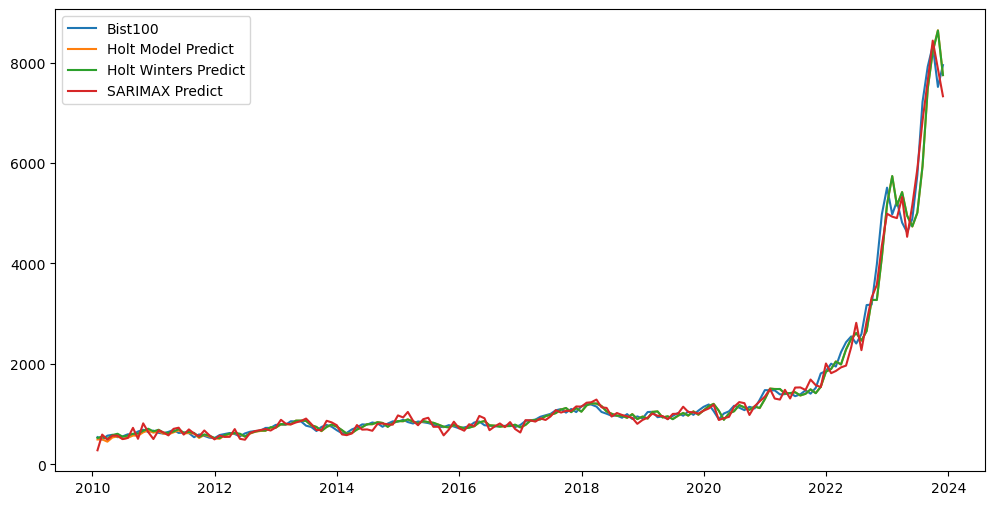

In [49]:
plt.figure(figsize=(12,6))
plt.plot(df)
plt.legend(df.columns)
plt.show()